<a href="https://colab.research.google.com/github/JairEsc/Aprendizaje/blob/main/ML/pre_trained_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_pretrained_bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.9 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
from transformers import BertTokenizer
from transformers import BertModel as BertModel2

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from collections import Counter

import argparse
import functools

import json
import numpy as np

from tqdm import tqdm
import shutil
import os

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import pandas as pd


In [4]:
import kagglehub
from os import listdir

path=kagglehub.dataset_download("saurabhshahane/ecommerce-text-classification")

100%|██████████| 7.86M/7.86M [00:01<00:00, 5.68MB/s]

Extracting files...


In [5]:
listdir(path)

['ecommerceDataset.csv']

In [6]:
data=pd.read_csv(path+"/ecommerceDataset.csv",names=["label","product_description"])

In [7]:
pd.DataFrame.head(data)

,label,product_description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [8]:
data["type"]=data.product_description.apply(lambda e: isinstance(e,str))
#Para cada descripcion, revisa si es un string. Si lo es, en el campo type agrega true.

In [9]:
data[data.type==False]#Hay 39330 sin descripcion de producto.

,label,product_description,type
39330,Clothing & Accessories,NaN,False


In [10]:
data=data[data.type==True]

In [11]:
print("Tamaño del data set: ",len(data))

Tamaño del data set:  50424


In [12]:
# prompt: tomemos un subconjunto aleatorio de 0.15 del dataset data

#Tomemos un subconjunto aleatorio de 0.15 del dataset data
data_subset = data.sample(frac=0.15, random_state=42) # random_state asegura reproducibilidad
print("Tamaño del subconjunto de datos: ", len(data_subset))

Tamaño del subconjunto de datos:  7564


<Axes: title={'center': 'Número de productos por categoría'}, xlabel='label'>

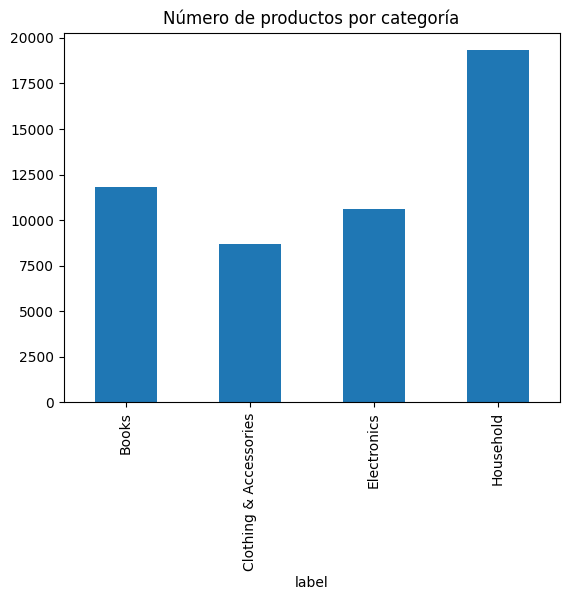

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='bar', title='Número de productos por categoría')

In [39]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_subset, test_size=0.1, random_state=42)

In [41]:
train_set, val_set = train_test_split(train_set, test_size=0.11, random_state=42)

In [44]:
train_set.to_csv("train.csv")
val_set.to_csv("val.csv")
test_set.to_csv("test.csv")

In [16]:
# prompt: muestra los tamaños de train, val, test

print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(val))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 6058
Tamaño del conjunto de validación: 749
Tamaño del conjunto de prueba: 757


## Procesamiento del Dataset

In [ ]:
###Será mucho código.

Procesamiento del dataset

Los siguientes 4 bloques no entiendo bien para qué son o si son necesarios.

In [17]:
class EcommerceDataset(Dataset):
    def __init__(self, data_path, args):
        """
          data_path: ruta del archivo .csv que contiene labels y product_descriptions
          args: hiperparámetros

        """
        self.data = pd.read_csv(data_path)
        self.tokenizer = BertTokenizer.from_pretrained(args.bert_model) #función preprocesa y divide el texto en tokens
        self.args = args
        self.n_classes = len(args.labels)#En nuestro caso son 4 clases
        self.max_seq_len = args.max_seq_len #512


    def __len__(self):
        return len(self.data)#longitud de los datos

    def load_text(self, index, key=""):
      inputs=self.tokenizer(self.data.loc[index][key], return_tensors="pt", padding='max_length',truncation=True)
      sentence=inputs.input_ids[0]
      segment=inputs.token_type_ids[0]
      attmask=inputs.attention_mask[0]

      return sentence, segment, attmask



    def __getitem__(self, index):
      sentence, segment, attmask = None, None, None

      # Load text
      sentence, segment, attmask= self.load_text(index,"product_description")


      # Process labels
      label = torch.zeros(self.n_classes)
      tgt = self.data.loc[index]["label"]
      label[self.args.labels.index(tgt)] = 1


      return sentence, segment, attmask, label

In [18]:
def get_labels_and_frequencies(path):
    label_freqs = Counter()
    data_labels = list(pd.read_csv(path).label)
    label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

In [19]:
def collate_fn(batch, args):

    text_tensor, segment_tensor, attmask_tensor,= None, None, None

    text_tensor=torch.stack([row[0] for row in batch])
    segment_tensor=torch.stack([row[1] for row in batch])
    attmask_tensor=torch.stack([row[2] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    return text_tensor, segment_tensor, attmask_tensor, tgt_tensor

In [20]:
def get_data_loaders(args):

  args.labels, args.label_freqs = get_labels_and_frequencies(
            os.path.join(args.data_path, args.task, "train.csv")
        )

  args.n_classes = len(args.labels)

  train = EcommerceDataset(
            os.path.join(args.data_path, "train.csv"),
            args,
        )

  args.train_data_len = len(train)

  dev = EcommerceDataset(
        os.path.join(args.data_path, "val.csv"),
        args,
    )

  test_set = EcommerceDataset(
        os.path.join(args.data_path, "test.csv"),
        args
    )

  collate = functools.partial(collate_fn, args=args)

  train_loader = DataLoader(
        train,
        batch_size=args.batch_sz,
        shuffle=True,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  val_loader = DataLoader(
        dev,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )
  test_loader = DataLoader(
        test_set,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  return train_loader, val_loader, test_loader

#Configuracion del entrenamiento

In [21]:
import random
#Para reproducción de resultados
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
def model_forward(i_epoch, model, args, criterion, batch):

    txt, segment, attmask, tgt= batch
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()
    out = model(txt, attmask, segment) #out for supervised loss

    tgt = tgt.cuda()
    final_loss = criterion(out, tgt)

    return final_loss, out, tgt

In [23]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report

In [24]:
def model_eval(i_epoch, data, model, args, criterion):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        probs= []
        for batch in data:
            loss, out, tgt = model_forward(i_epoch, model, args, criterion, batch)
            losses.append(loss.item())

            prob = torch.nn.functional.softmax(out,dim=-1).cpu().detach().numpy()
            index_max = prob.argmax(axis=-1)
            pred = np.zeros(prob.shape)
            for i in range(len(index_max)):
                pred[i][index_max[i]]=1


            preds.append(pred)
            probs.append(prob)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    probs = np.vstack(probs)
    report = classification_report(tgts, preds, output_dict=True)
    #print(report)
    metrics = {"loss": np.mean(losses)}
    metrics = {"weighted avg": report['weighted avg']}

    return metrics

In [25]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

In [26]:
def train(args,model):
    args.savedir = os.path.join(args.savedir, args.name)
    os.makedirs(args.savedir, exist_ok=True)

    model.cuda()

    torch.save(args, os.path.join(args.savedir, "args.pt"))

    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    #Cargar estado del modelo si ya existía previamente
    if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

    len_train =len(train_loader)
    for i_epoch in range(start_epoch, args.max_epochs):
        train_losses = []
        model.train()
        optimizer.zero_grad()

        for batch in tqdm(train_loader, total=len_train):
            loss, _, _ = model_forward(i_epoch, model, args, criterion, batch)
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            train_losses.append(loss.item())
            loss.backward()
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval() #desactiva el dropout
        metrics= model_eval(i_epoch, val_loader, model, args, criterion)
        print("Train Loss: {:.4f}".format(np.mean(train_losses)))
        print("Val:", metrics)

        tuning_metric = (
            metrics['weighted avg']['f1-score']
        )

        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        #Guardar estado actual del modelo
        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
              print("No improvement. Breaking out of loop.")
              break

    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()
    test_metrics= model_eval(
        np.inf, test_loader, model, args, criterion
    )
    print(f"Test:", test_metrics)

In [27]:
def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])

#Ahora sí usar BERT

In [28]:
class BertClf(nn.Module):
    def __init__(self, args):
        super(BertClf, self).__init__()
        self.args = args
        self.bert = BertModel2.from_pretrained(args.bert_model) #Encoder
        self.dropout= nn.Dropout(args.dropout)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes) #Cabezal de clasificación

    def forward(self, txt, mask, segment):
        _, x = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        x= self.dropout(x)
        return self.clf(x)

In [29]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="bert",
        batch_sz=8,
        max_seq_len=512,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=10,
        patience=2,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="bert_base_1",
    )

In [45]:
train_loader, val_loader, test_loader = get_data_loaders(args)

In [46]:
#Modelo
bert_base = BertClf(args)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [47]:
bert_base.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [48]:
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(bert_base.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

In [49]:
train(args,bert_base)

100%|██████████| 758/758 [09:09<00:00,  1.38it/s]


Train Loss: 0.0275
Val: {'weighted avg': {'precision': 0.9256845618709042, 'recall': 0.9238985313751669, 'f1-score': 0.9240451815015521, 'support': 749.0}}


100%|██████████| 758/758 [09:09<00:00,  1.38it/s]


Train Loss: 0.0105
Val: {'weighted avg': {'precision': 0.959220313667842, 'recall': 0.9586114819759679, 'f1-score': 0.9585680122017362, 'support': 749.0}}


100%|██████████| 758/758 [09:09<00:00,  1.38it/s]


Train Loss: 0.0071
Val: {'weighted avg': {'precision': 0.9573503760019354, 'recall': 0.9572763684913218, 'f1-score': 0.9572966027529162, 'support': 749.0}}


100%|██████████| 758/758 [09:09<00:00,  1.38it/s]


Train Loss: 0.0051
Val: {'weighted avg': {'precision': 0.9539178470130963, 'recall': 0.9532710280373832, 'f1-score': 0.953324359776807, 'support': 749.0}}
No improvement. Breaking out of loop.


<ipython-input-27-c8ce07a6b21e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(path)


Test: {'weighted avg': {'precision': 0.9528135982424984, 'recall': 0.952443857331572, 'f1-score': 0.9522542511988138, 'support': 757.0}}


In [50]:
def model_predict(model,text,args):
  with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    inputs=tokenizer(text, return_tensors="pt", padding='max_length',truncation=True)
    txt=inputs.input_ids
    segment=inputs.token_type_ids
    attmask=inputs.attention_mask
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()

    out = bert_base(txt, attmask, segment)
    prob = torch.nn.functional.softmax(out[0],dim=0)
    index_max = prob.argmax(axis=0)
    pred= args.labels[index_max]

  return pred, prob

In [51]:
text="GoPro Fetch Dog Harness Mount for Camera Style name:Fetch (Dog Harness) GoPro harnais pour chiens - fetch pour HERO 1, 2, 3, 3+, 4."
model_predict(bert_base,text,args)

('Electronics',
 tensor([9.3542e-02, 1.9501e-02, 8.8614e-01, 8.2009e-04], device='cuda:0'))

In [52]:
text="Speech and Language Processing Pasta dura – Illustrated, 1 abril 2008  Edición Inglés  por Daniel Jurafsky (Autor), James Martin (Autor) For undergraduate or advanced undergraduate courses in Classical Natural Language Processing, Statistical Natural Language Processing, Speech Recognition, Computational Linguistics, and Human Language Processing. An explosion of Web-based language techniques, merging of distinct fields, availability of phone-based dialogue systems, and much more make this an exciting time in speech and language processing. The first of its kind to thoroughly cover language technology - at all levels and with all modern technologies - this text takes an empirical approach to the subject, based on applying statistical and other machine-learning algorithms to large corporations. The authors cover areas that traditionally are taught in different courses, to describe a unified vision of speech and language processing. Emphasis is on practical applications and scientific evaluation. An accompanying Website contains teaching materials for instructors, with pointers to language processing resources on the Web. The Second Edition offers a significant amount of new and extended material"
model_predict(bert_base,text,args)

('Books',
 tensor([1.4079e-04, 9.9918e-01, 5.0394e-04, 1.7874e-04], device='cuda:0'))